# How to model immunity

In this tutorial, we are going to simulate the spread of Covid-19 in the case of a virus variant that is potentially resistant to immunity.

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sid
from sid.config import INDEX_NAMES

warnings.filterwarnings("ignore")
np.random.seed(0)

## Preparation

For the simulation we need to prepare several objects which are identical to the ones from the general tutorial on the [simulation](how_to_simulate.ipynb) and the tutorial on simulating [multiple virus strain](how_to_simulate_multiple_virus_strains.ipynb). Because of the equivalence to these tutorials we won't print the variables.

In [2]:
available_ages = [
    "0-9",
    "10-19",
    "20-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-100",
]

ages = np.random.choice(available_ages, size=10_000)
regions = np.random.choice(["North", "South"], size=10_000)

initial_states = pd.DataFrame({"age_group": ages, "region": regions}).astype("category")

In [3]:
def meet_distant(states, params, seed):
    possible_nr_contacts = np.arange(10)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


def meet_close(states, params, seed):
    possible_nr_contacts = np.arange(5)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


assort_by = ["age_group", "region"]

contact_models = {
    "distant": {"model": meet_distant, "assort_by": assort_by, "is_recurrent": False},
    "close": {"model": meet_close, "assort_by": assort_by, "is_recurrent": False},
}

epidemiological_parameters = pd.read_csv("infection_probs.csv", index_col=INDEX_NAMES)

assort_probs = pd.read_csv("assort_by_params.csv", index_col=INDEX_NAMES)

disease_params = sid.load_epidemiological_parameters()

params = pd.concat([disease_params, epidemiological_parameters, assort_probs])

## Additional objects to implement virus strain dependent immunity

We have to make the following extensions to the model:

1. Add a multiplier for the contagiousness of each virus to the parameters.
2. Add a factor for the resistancy of each virus to the parameters.
3. Prepare a DataFrame for the initial conditions.

In [4]:
for virus, cf, irf in [("base", 1, 1), ("b117", 1.3, 0.5)]:
    params.loc[("virus_strain", virus, "contagiousness_factor"), "value"] = cf
    params.loc[("virus_strain", virus, "immunity_resistance_factor"), "value"] = irf

### Interpreting ``immunity_resistance_factor``

The interpretation of the immunity resistance factor is straightforward. Say individual $i$ meets the infectious individual $j$ and there is a probability $p(i,j)$ that $j$ infects $i$. Now individual $i$ already has a non-zero immunity level $\text{immunity}[i]$, either through vaccination or through a prior infection. Let $\text{IRF}$ denote the immunity resistance factor corresponding to the virus strain passed on by individual $j$. Then the infection probability is simply updated with a multiplicative factor:

\begin{align}
p(i, j) \leftarrow p(i, j) \times (1 - \text{IRF} \times \text{immunity}[i]).
\end{align}

So, $\text{IRF} = 0$ means that immunity **cannot** affect the infection probability, while $\text{IRF} = 1$ means that the immunity level affects the infection probability directly.

### Initial conditions

For the initial conditions, we assume a two-day burn-in period. On the first day, 50 people are infected with the base virus, on the second day one halve of 50 people has the old and the other halve the new variant.

Each column in the DataFrame is a categorical. Infected individuals have a code for the variant, all others have NaNs.

In [5]:
infected_first_day = set(np.random.choice(10_000, size=50, replace=False))
first_day = pd.Series([pd.NA] * 10_000)
first_day.iloc[list(infected_first_day)] = "base"

In [6]:
infected_second_day_old_variant = set(
    np.random.choice(
        list(set(range(10_000)) - infected_first_day), size=25, replace=False
    )
)
infected_second_day_new_variant = set(
    np.random.choice(
        list(set(range(10_000)) - infected_first_day - infected_second_day_old_variant),
        size=25,
        replace=False,
    )
)

second_day = pd.Series([pd.NA] * 10_000)
second_day.iloc[list(infected_second_day_old_variant)] = "base"
second_day.iloc[list(infected_second_day_new_variant)] = "b117"

In [7]:
initial_infections = pd.DataFrame(
    {
        pd.Timestamp("2020-02-25"): pd.Categorical(
            first_day, categories=["base", "b117"]
        ),
        pd.Timestamp("2020-02-26"): pd.Categorical(
            second_day, categories=["base", "b117"]
        ),
    }
)

In [8]:
initial_conditions = {"initial_infections": initial_infections, "initial_immunity": 50}

## Run the simulation

Now we will simulate this population over 200 periods. To compare the effects of the immunity resistance parameter we run the simulation for three parameter values: 0, 0.5 and 1.

In [9]:
resistance_factors = [0, 0.5, 1]

df_dict = {}
for value in resistance_factors:

    # update the immunity resistance factor
    params.loc[("virus_strain", "b117", "immunity_resistance_factor"), "value"] = value

    # simulate
    simulate = sid.get_simulate_func(
        initial_states=initial_states,
        contact_models=contact_models,
        params=params,
        initial_conditions=initial_conditions,
        duration={"start": "2020-02-27", "periods": 365},
        virus_strains=["base", "b117"],
        seed=0,
    )

    result = simulate(params=params)
    df_dict[value] = result["time_series"].compute()

Start the simulation...
2021-02-25: 100%|██████████| 365/365 [00:33<00:00, 10.95it/s]
Start the simulation...
2021-02-25: 100%|██████████| 365/365 [00:30<00:00, 11.84it/s]
Start the simulation...
2021-02-25: 100%|██████████| 365/365 [00:31<00:00, 11.74it/s]


Let us take a look at various statistics of the sample.

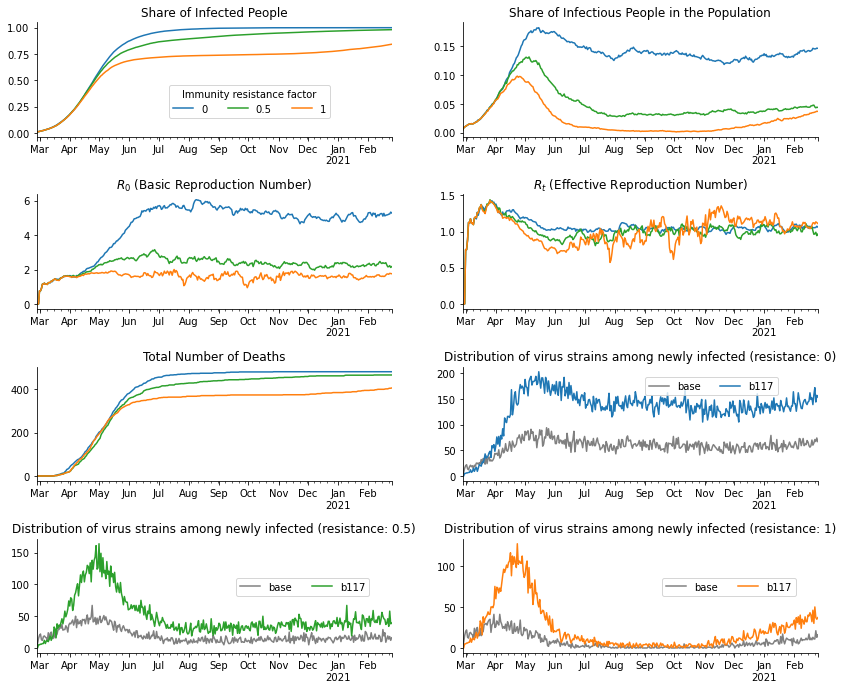

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(14, 12))
fig.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.5)

axs = axs.flatten()

value_to_ax = {0: 5, 0.5: 6, 1: 7}

for value, color in [(0, "tab:blue"), (0.5, "tab:green"), (1, "tab:orange")]:

    df_dict[value].resample("D", on="date")["ever_infected"].mean().plot(
        ax=axs[0], color=color, label=value
    )
    df_dict[value].resample("D", on="date")["infectious"].mean().plot(
        ax=axs[1], color=color
    )
    df_dict[value].resample("D", on="date")["dead"].sum().plot(ax=axs[4], color=color)

    r_zero = sid.statistics.calculate_r_zero(df_dict[value], window_length=7)
    r_zero.plot(ax=axs[2], color=color)

    r_effective = sid.statistics.calculate_r_effective(df_dict[value], window_length=7)
    r_effective.plot(ax=axs[3], color=color)

    _df = (
        df_dict[value]
        .query("newly_infected")
        .groupby([pd.Grouper(key="date", freq="D"), "virus_strain"])["newly_infected"]
        .count()
        .unstack()
    )
    _df["base"].plot(ax=axs[value_to_ax[value]], color="grey")
    _df["b117"].plot(ax=axs[value_to_ax[value]], color=color)

for ax in axs:
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

axs[0].legend(
    loc="upper center",
    bbox_to_anchor=(0.60, 0.50),
    ncol=3,
    title="Immunity resistance factor",
)
axs[5].legend(loc="upper center", bbox_to_anchor=(0.70, 0.95), ncol=2)
axs[6].legend(loc="upper center", bbox_to_anchor=(0.75, 0.70), ncol=2)
axs[7].legend(loc="upper center", bbox_to_anchor=(0.75, 0.70), ncol=2)

axs[0].set_title("Share of Infected People")
axs[1].set_title("Share of Infectious People in the Population")
axs[2].set_title("$R_0$ (Basic Reproduction Number)")
axs[3].set_title("$R_t$ (Effective Reproduction Number)")
axs[4].set_title("Total Number of Deaths")
axs[5].set_title("Distribution of virus strains among newly infected (resistance: 0)")
axs[6].set_title("Distribution of virus strains among newly infected (resistance: 0.5)")
axs[7].set_title("Distribution of virus strains among newly infected (resistance: 1)")

plt.show()